In [2]:

import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

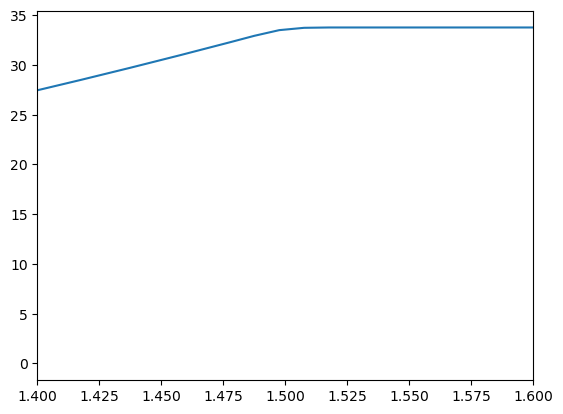

In [10]:
a = 10
alpha = 3
c = 1.5
coeff = 10

x = np.linspace(-3, 3, 600)
y = np.linspace(-3, 3, 600)
x_mesh, y_mesh = np.meshgrid(x, y)
f = np.zeros(x_mesh.shape)
avg_f = np.zeros(x_mesh.shape)

for j, yj in enumerate(y):
    for i, xi in enumerate(x):
        r = np.sqrt(xi**2 + yj**2)
        theta = np.arctan2(xi, yj)
        if r < c:
            f[i,j] = coeff*r**alpha
        else:
            f[i,j] = coeff*c**alpha
            
for j, yj in enumerate(y):
    for i, xi in enumerate(x):
        r = np.sqrt(xi**2 + yj**2)
        if c - c/5.0 < r < c + c/5.0:
            avg_f[i,j] = (f[i+1,j] + f[i,j+1] + f[i-1,j] + f[i,j-1] + f[i,j])/5.0
        else:
            avg_f[i,j] = f[i,j]
        

# plt.pcolor(avg_f)
plt.plot(y,avg_f[300, :])
plt.xlim(c-0.1, c+0.1)

plt.show()

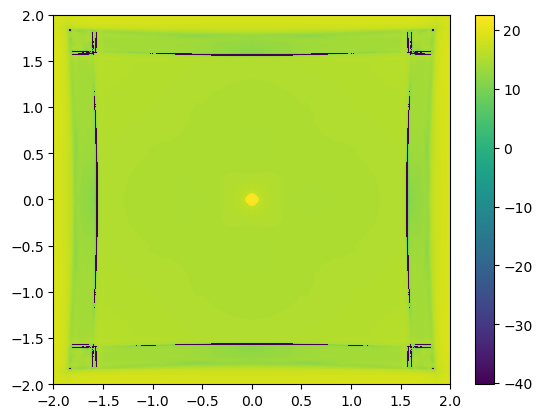

In [35]:
testdir = "/mnt/gs21/scratch/freem386/lhlld_pspace2/"
testfile = "al2_be2_p1_d1_b1.out2.00100.athdf"

fileh5 = h5py.File(testdir+testfile, 'r')
X, Y = np.meshgrid(fileh5['x1f'], fileh5['x2f'])
dset = fileh5['prim']
plt.pcolormesh(X, Y, np.log(dset[1, 0, 0, :, :]))
plt.colorbar()
plt.show()

In [9]:
data = pickle.load(open("lhlld2_stability.pkl", 'rb'))
print(data[0, 0, 0, 0, 0, :])

[4.99999988e+01 3.44302569e+02 6.35434172e+02 9.11871117e+02
 1.18210374e+03 1.44874459e+03 1.71317233e+03 1.97699953e+03
 2.24073963e+03 2.50467872e+03 2.76621182e+03 3.01965373e+03
 3.26951676e+03 3.52318508e+03 3.46944695e-18 4.01846396e+03
 4.25837877e+03 3.46944695e-18 4.74030275e+03 3.46944695e-18
 5.20739528e+03 5.43583575e+03 3.46944695e-18 5.89179918e+03
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 9.61788710e+03 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.46944695e-18 3.46944695e-18 3.46944695e-18
 3.46944695e-18 3.469446

In [8]:
data = pickle.load(open("lhlld2_stability.pkl", 'rb'))
print(data[0, 0, 0, 0, 0, :])

[9.99999977e+01 6.88605138e+02 1.27086834e+03 1.82374223e+03
 2.36420749e+03 2.89748919e+03 3.42634465e+03 3.95399906e+03
 4.48147927e+03 5.00935744e+03 5.53242364e+03 6.03930746e+03
 6.53903352e+03 7.04637015e+03 6.93889390e-18 8.03692791e+03
 8.51675754e+03 6.93889390e-18 9.48060550e+03 6.93889390e-18
 1.04147906e+04 1.08716715e+04 6.93889390e-18 1.17835984e+04
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 1.92357742e+04 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.93889390e-18 6.93889390e-18 6.93889390e-18
 6.93889390e-18 6.938893